In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)

PROCESSING IMAGES

In [2]:
labels = ("glioma", "meningioma", "notumor", "pituitary")
img_dim = (512, 512)

In [70]:
import numpy as np
import os
import cv2

def load_images_dataset(label, num_images, img_dim):
    root = os.path.join(os.getcwd(), 'data') # get system path to data folder
    path = os.path.join(root, label) # get path to label folder
    file_paths = os.listdir(path) # list all files

    random_select = np.random.choice(file_paths, num_images, replace=False) # get N random selection of files
    images = []
    for f in random_select:                                                 # Preprocess images
        img_path = os.path.join(path, f)                                    # Get full file path
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)                    # Read image as grayscale
        img = cv2.resize(img, img_dim, interpolation=cv2.INTER_LINEAR)      # Resize image to correct dimensions
        normalized_img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)    # normalize image
        images.append(normalized_img)

    return images

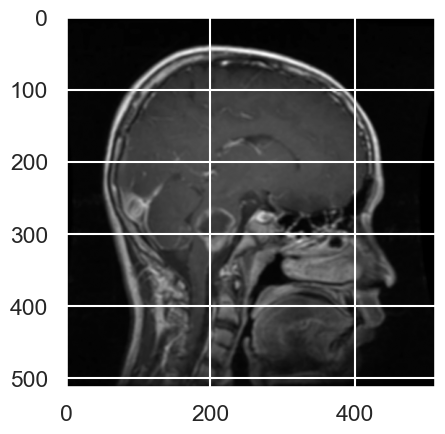

In [4]:
images = load_images_dataset('glioma', 200, 5, img_dim)
plt.imshow(images[1], cmap='gray')

In [71]:
def convert_images_to_np_array(img_list):
    size = len(img_list)
    num_col = img_list[0].shape[0] * img_list[0].shape[1]   # get number of cols by multiplying dims of first image, all same dim

    for i in range(size):
        img_list[i] =  np.ndarray.flatten(img_list[i]).reshape(num_col, 1)      # flatten image

    img_stack = np.dstack(img_list)                                             # Remove extra axis
    img_stack = np.rollaxis(img_stack, axis = 2, start = 0)
    img_stack = img_stack.reshape(size, num_col)

    return img_stack


In [72]:
from sklearn.utils import shuffle
def create_dataframe(num_images, img_dim):

    df_list = []

    for l in labels:    # for each label
        temp_list = load_images_dataset(l, num_images, img_dim)    # load images
        temp_array = convert_images_to_np_array(temp_list)                      # convert images to np arraies
        temp_df = pd.DataFrame(temp_array)                                      # convert each array to a df
        temp_df['label'] = l                                                    # add corresponding label to group of images
        df_list.append(temp_df)

    act = pd.concat(df_list, ignore_index=True)         # combine dataframes into one
    final = shuffle(act).reset_index()                  # shuffle images
    final = final.drop(columns=['index'], axis=1)       # drop unneeded index col

    return final

In [73]:
df = create_dataframe(num_images=200, img_dim=img_dim)
print(df.shape)
df.head()
df.tail()

(800, 262145)


,0,1,2,3,4,5,6,7,8,9,...,262135,262136,262137,262138,262139,262140,262141,262142,262143,label
795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pituitary
796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pituitary
797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,glioma
798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,glioma
799,3,3,3,3,3,3,2,2,2,2,...,3,3,4,4,4,4,4,4,4,notumor


In [25]:
from sklearn.preprocessing import StandardScaler


def split_x_and_y(df):

    x = df.iloc[:, :-1] # get image data from data frame
    y = df.iloc[:, -1]  # get label data from data frame

    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)

    return (x_scaled, y)

SUPERVISED LEARNING MODEL

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

def multiclass_logistic_regression(solver, test_size, random_state, df):

    x, y = split_x_and_y(df)    # split the image data from the labels

    x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=test_size, random_state=random_state)
    mlr = LogisticRegression(solver=solver, C=0.001).fit(x_train, y_train)

    y_pred = mlr.predict(x_test)

    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    precision_score = metrics.precision_score(y_test, y_pred, average='macro')
    recall_score = metrics.recall_score(y_test, y_pred, average='macro')
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred, average='macro')

    return (accuracy_score, precision_score, recall_score, confusion_matrix, f1_score)

In [74]:
def get_single_result_mlr(size, img_dim, solver, test_size, random_state):
    df = create_dataframe(size, img_dim)
    return multiclass_logistic_regression(solver, test_size, random_state, df)

In [80]:
def train_mlr_gather_results(options, test_var, size=1000, solver="newton-cg", test_size=0.2, random_state=42, img_dim=img_dim):

    scores = {}

    match test_var:
        case "n":
            for size_o in options:
                scores[size_o] = get_single_result_mlr(size_o, img_dim, solver, test_size, random_state)
                print(f"{size_o}: complete.")
        case "s":
            for solver_o in options:
                scores[solver_o] = get_single_result_mlr(size, img_dim, solver_o, test_size, random_state)
                print(f"{solver_o}: complete.")
        case "k":
            print("Removed Blur to images.")
            # for kernel_size_o in options:
                # scores[kernel_size_o] = get_single_result_mlr(size, kernel_size_o, img_dim, solver, test_size, random_state)
                # print(f"{kernel_size_o}: complete.")

    return scores

In [77]:
from sklearn.model_selection import GridSearchCV

df = create_dataframe(num_images=1000, img_dim=img_dim)

x, y = split_x_and_y(df)    # split the image data from the labels

x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=42)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}    # Test out common values for C

log_reg = LogisticRegression(penalty='l2', solver='newton-cg')

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Get the best C value
best_c = grid_search.best_params_['C']
print(f"Best C value: {best_c}")

TypeError: create_dataframe() got an unexpected keyword argument 'kernal_size'

In [50]:
def test_hyperparams(options, test_var, output_file_name):
    results = train_mlr_gather_results(options, test_var=test_var)
    results_string = str(results)

    with open(output_file_name, 'w') as file:
        file.write(results_string)

    print(results_string)

    return results

In [28]:
# Test out various solvers and compare results
options = ('newton-cg', 'sag', 'saga')
output_file_name = 'solver_test_results.txt'
test_var = 's'
results = test_hyperparams(options, test_var, output_file_name)

newton-cg: complete.


C:\Users\Ash\PycharmProjects\JupyterProject\.venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



sag: complete.


C:\Users\Ash\PycharmProjects\JupyterProject\.venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



saga: complete.
{'newton-cg': (0.68875, 0.6846600996352447, 0.6863553284976561, array([[106,  82,   5,  16],
       [ 67,  96,   8,  18],
       [  2,   8, 195,   8],
       [ 12,  18,   5, 154]]), 0.6848490278551562), 'sag': (0.69, 0.67027269982015, 0.675183036235141, array([[ 97,  67,   8,  12],
       [ 77,  78,   5,  27],
       [  4,   4, 199,  11],
       [ 18,   8,   7, 178]]), 0.6714259443496008), 'saga': (0.6775, 0.6639675951315094, 0.6742528305028305, array([[112,  54,   8,  22],
       [ 81,  73,  13,  31],
       [ 10,   2, 190,   6],
       [ 15,  15,   1, 167]]), 0.6651152851365493)}


(0.6, 0.7)

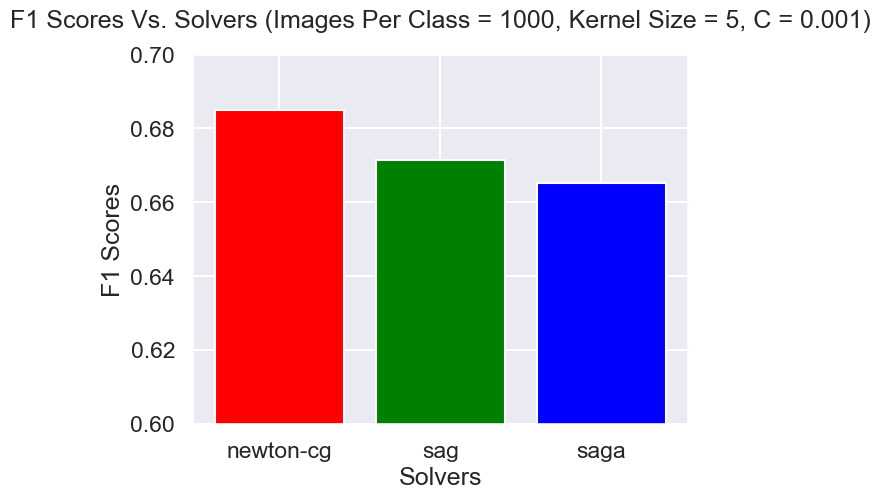

In [37]:
import matplotlib.pyplot as plt

categories = options
colors = ['red', 'green', 'blue']
accuracies = [value[0] for value in results.values()]
precisions = [value[1] for value in results.values()]
recalls = [value[2] for value in results.values()]
f1_scores = [value[4] for value in results.values()]

plt.bar(categories, f1_scores, color=colors)
plt.xlabel('Solvers')
plt.ylabel('F1 Scores')
plt.title('F1 Scores Vs. Solvers (Images Per Class = 1000, Kernel Size = 5, C = 0.001)', y=1.05)
plt.ylim(0.6, 0.7)


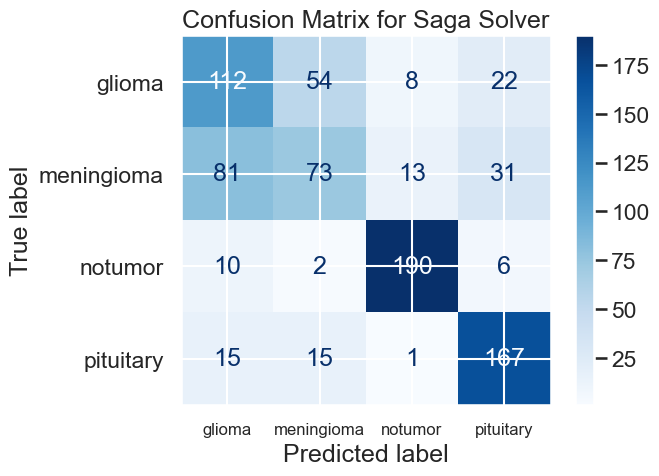

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_new = results['newton-cg'][3]
cm_sag = results['sag'][3]
cm_saga = results['saga'][3]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_saga, display_labels=labels)
disp.plot(cmap=plt.cm.Blues) # Customize colormap if desired
disp.ax_.set_xticklabels(labels, fontsize=12)
plt.title("Confusion Matrix for Saga Solver")
plt.show()


plt.show()

In [53]:
# Test out various kernel sizes for blur and compare results
options = (3, 5, 7)
output_file_name = 'kernel_test_results.txt'
test_var = 'k'
results = test_hyperparams(options, test_var, output_file_name)

3: complete.
5: complete.
7: complete.
{3: (0.6975, 0.6983372412851037, 0.6971081561595878, array([[111,  51,   6,  11],
       [ 90,  94,   9,  19],
       [  8,   6, 189,   4],
       [ 20,  16,   2, 164]]), 0.6938535251764495), 5: (0.69, 0.6923503564501565, 0.6912239859973872, array([[108,  72,   1,  17],
       [ 69, 100,  11,  22],
       [  7,   7, 174,   3],
       [ 21,  17,   1, 170]]), 0.6916821456127826), 7: (0.66875, 0.6774664555387641, 0.6713868244491452, array([[115,  75,  10,  10],
       [ 70,  98,   6,  23],
       [  5,  16, 168,   4],
       [ 19,  22,   5, 154]]), 0.6741557770453138)}


(0.6, 0.7)

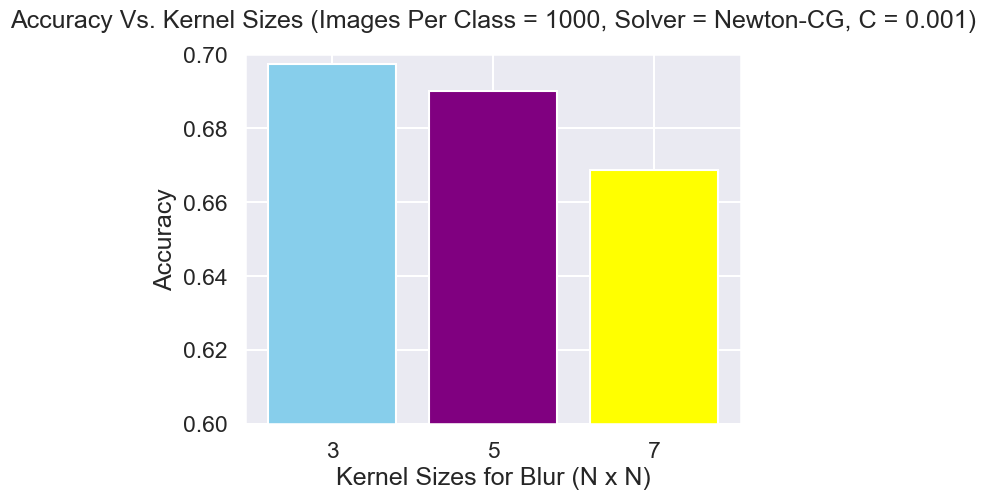

In [67]:
categories = ("3", "5", "7")
colors = ['red', 'green', 'blue']
colors = ['skyblue', 'purple', 'yellow']
accuracies = [value[0] for value in results.values()]
precisions = [value[1] for value in results.values()]
recalls = [value[2] for value in results.values()]
f1_scores = [value[4] for value in results.values()]

plt.bar(categories, accuracies, color=colors)
plt.xlabel('Kernel Sizes for Blur (N x N)')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs. Kernel Sizes (Images Per Class = 1000, Solver = Newton-CG, C = 0.001)', y=1.05)
plt.ylim(0.6, 0.7)

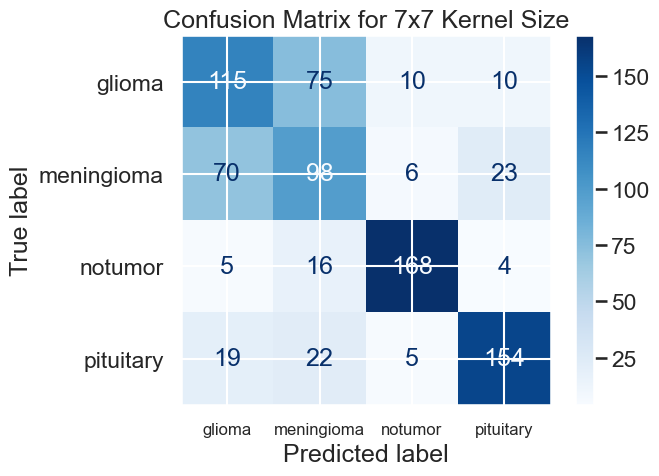

In [63]:
cm_3 = results[3][3]
cm_5 = results[5][3]
cm_7 = results[7][3]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_7, display_labels=labels)
disp.plot(cmap=plt.cm.Blues) # Customize colormap if desired
disp.ax_.set_xticklabels(labels, fontsize=12)
plt.title("Confusion Matrix for 7x7 Kernel Size")

plt.show()

In [81]:
# Test out various kernel sizes for blur and compare results
options = (100, 200, 500, 1000, 2000)
output_file_name = 'image_size_test_results.txt'
test_var = 'n'
results = test_hyperparams(options, test_var, output_file_name)

100: complete.
200: complete.
500: complete.
1000: complete.
2000: complete.
{100: (0.525, 0.547360248447205, 0.5531818181818182, array([[11, 12,  0,  2],
       [ 8,  6,  4,  4],
       [ 1,  4, 10,  0],
       [ 2,  1,  0, 15]]), 0.5484094286735519), 200: (0.70625, 0.6833339532807617, 0.7014976958525345, array([[21,  8,  0,  2],
       [17, 15,  5,  5],
       [ 0,  4, 39,  2],
       [ 1,  3,  0, 38]]), 0.686750936329588), 500: (0.7, 0.6887909404975585, 0.700236400722559, array([[69, 22,  5,  4],
       [42, 39,  7, 13],
       [ 0,  5, 95,  7],
       [ 4, 10,  1, 77]]), 0.6910467056476071), 1000: (0.7075, 0.7009474866721194, 0.7099214006256548, array([[118,  74,   4,  20],
       [ 63,  99,  10,  21],
       [  6,   8, 200,   6],
       [  3,  15,   4, 149]]), 0.7038773318582778), 2000: (0.739375, 0.7424613656147644, 0.7401829007965948, array([[235, 139,   7,  17],
       [129, 234,  11,  27],
       [  1,   3, 382,   5],
       [ 22,  51,   5, 332]]), 0.7407965607568783)}


Text(0.5, 1.05, 'F1 Scores Vs. Number of Images Per Class (Solver = Newton-CG, C = 0.001)')

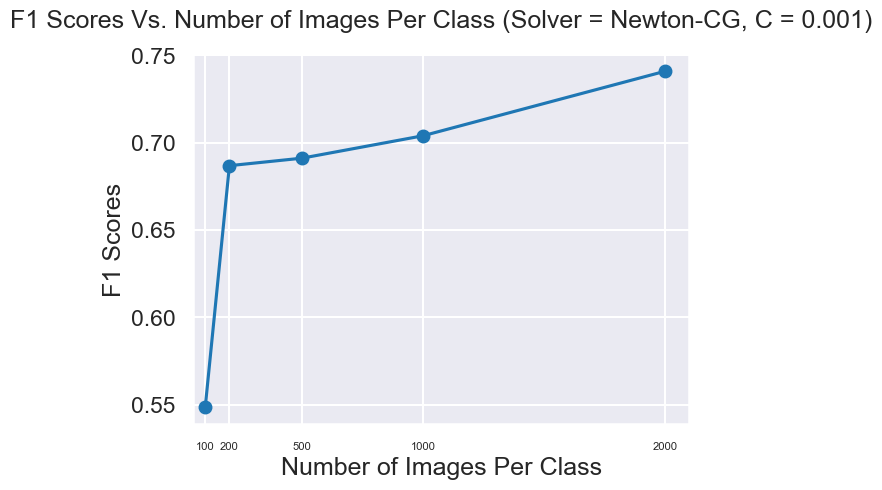

In [100]:
accuracies = [value[0] for value in results.values()]
precisions = [value[1] for value in results.values()]
recalls = [value[2] for value in results.values()]
f1_scores = [value[4] for value in results.values()]

fig, ax = plt.subplots()
ax.plot(options, f1_scores, '-o')
plt.xlim(50, 2100)
ax.set_xticks(options)
plt.xticks(fontsize=8)
plt.xlabel('Number of Images Per Class')
plt.ylabel('F1 Scores')
plt.title('F1 Scores Vs. Number of Images Per Class (Solver = Newton-CG, C = 0.001)', y=1.05)

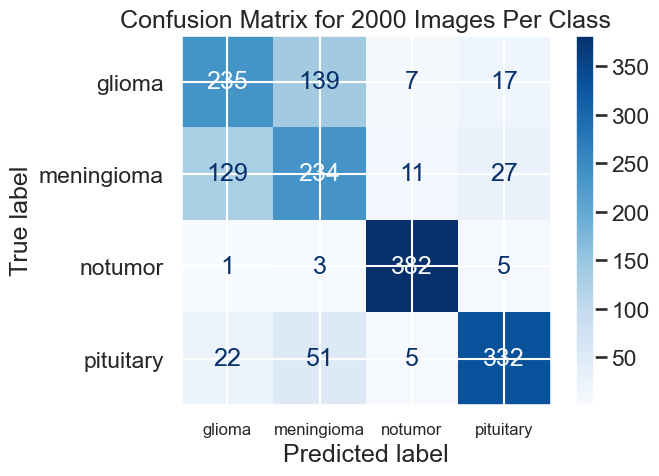

In [105]:
cm_100 = results[100][3]
cm_200 = results[200][3]
cm_500 = results[500][3]
cm_1000 = results[1000][3]
cm_2000 = results[2000][3]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_2000, display_labels=labels)
disp.plot(cmap=plt.cm.Blues) # Customize colormap if desired
disp.ax_.set_xticklabels(labels, fontsize=12)
plt.title("Confusion Matrix for 2000 Images Per Class")

plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, r2_score

# Split features and labels
x, y = split_x_and_y(df)

# Apply K-means clustering with 4 clusters (one for each tumor type)
kmeans_model = KMeans(n_clusters=4, random_state=42, max_iter=300)
kmeans_model.fit(x)

# Get cluster predictions
y_pred_clusters = kmeans_model.predict(x)

# Map clusters to actual labels by finding the most common label in each cluster
cluster_to_label = {}
for cluster_id in range(4):
    mask = y_pred_clusters == cluster_id
    most_common_label = y[mask].mode()[0]
    cluster_to_label[cluster_id] = most_common_label

# Map predictions to actual label names
y_pred_mapped = [cluster_to_label[cluster] for cluster in y_pred_clusters]

# Calculate accuracy
accuracy = metrics.accuracy_score(y, y_pred_mapped)
print(f"K-means clustering accuracy: {accuracy * 100:.2f}%")

https://www.geeksforgeeks.org/machine-learning/sklearn-classification-metrics/
https://scikit-learn.org/stable/auto_examples/model_selection/plot_train_error_vs_test_error.html
https://www.geeksforgeeks.org/machine-learning/how-to-calculate-r2-with-scikit-learn/
https://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-ranking-metrics

https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/